# F1 Week 4 - Spatial Targeting Strategy

## When Standard BO Fails: A Degenerate Landscape Challenge

**F1's Unique Problem:**
- 92% of evaluations return identical outputs (f(x) = 0.000000)
- Only 1/13 points differs (f(x) = -0.0036)
- Gaussian Process predicts μ(x) ≈ 0 everywhere → **FLAT**
- Acquisition function collapses (EI ≈ 0 everywhere)
- Traditional BO provides **NO GUIDANCE**

**Week 3 Result:**
- Submission: [0.083, 1.540] 
- Value: 0.000000 ✓ (correct!)
- Rank: #10/13 ✗ (wrong location!)
- Issue: GP can't distinguish WHERE among identical values

---

## Week 4 Innovation: Bypass GP Entirely

**Problem Identified:**
> "When 92% of outputs are identical, value-based optimization fails.
> Need spatial optimization instead."

**New Approach - Spatial Targeting:**

### Step 1: Cluster Analysis
- Identify WHERE the best zeros are located (not WHAT value they have)
- Top 5 zeros cluster at [0.688, 0.725] - upper-right quadrant
- Bottom zeros scattered/out-of-bounds

### Step 2: Meta-Learning from F4
- F4 succeeded with tight exploitation (distance 0.121)
- Apply same strategy: sample near cluster center
- Radius: 0.12 (proven effective)

### Step 3: Direct Sampling
- **NO Gaussian Process** (it's flat and useless)
- **NO Acquisition Function** (EI ≈ 0 everywhere)
- Generate candidates: Normal(cluster_center, 0.12)
- Select: Closest to cluster center

### Step 4: Conservative Selection
- Pick point nearest to [0.688, 0.725]
- Expected result: [~0.69, ~0.73]
- In bounds, optimal location

---

## Why This Works

**Traditional BO (Failed):**
```
GP learns: "Everything → 0"
Acquisition: "All points equally good" 
Selection: Random
Result: Rank #10 ✗
```

**Spatial Targeting (Expected to work):**
```
Clustering: "Best zeros at [0.69, 0.73]"
Sampling: "Focus search on cluster"
Selection: Conservative (center)
Expected: Rank #1-3 ✓
```

---

## Expected Week 4 Outcome

**Submission:** [0.688, 0.724] (0.001 from cluster center)

**Predicted Results:**
- Value: 0.000000 (same as always in this region)
- Rank: #1-3 (improved from #10!)
- Distance from cluster: 1,014× closer than Week 3
- Strategy: Spatial pattern recognition > Flat GP

**Confidence: 90%**

**Key Innovation:** 
> When acquisition functions collapse due to data degeneracy,
> spatial clustering provides an effective alternative search signal.


In [29]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TensorFlow warnings

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, WhiteKernel
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

# TensorFlow for Neural Networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

sns.set_style('whitegrid')
print('='*80)
print('WEEK 4: ADAPTIVE MODEL SELECTION → GP')
print('='*80)

WEEK 4: ADAPTIVE MODEL SELECTION → GP


## Load Week 4 Data

In [30]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data - works for ANY function
X = np.load('f1_w4_inputs.npy')
Y = np.load('f1_w4_outputs.npy')

# DYNAMIC VARIABLES - automatically detected from data
n_samples = len(X)
n_dims = X.shape[1]
n_w3 = n_samples - 1  # All samples except the newest
w4_idx = n_samples - 1  # Last sample is W4 new point

print('='*80)
print(f'WEEK 4: RESULTS ANALYSIS')
print('='*80)

print(f'\nData: {n_samples} samples, {n_dims}D')
print(f'n/p ratio: {n_samples/n_dims:.2f}')

print(f'\nY statistics:')
print(f'  Range: {Y.min():.4f} to {Y.max():.4f}')
print(f'  Mean: {Y.mean():.4f} ± {Y.std():.4f}')

# Best point overall
best_idx = np.argmax(Y)
best_pt = X[best_idx]
best_val = Y[best_idx]

print(f'\nBest point (overall):')
print(f'  Index: {best_idx}')
print(f'  Value: {best_val:.6f}')
print(f'  Location: {best_pt}')

# Check boundary pattern
boundary_dims = [i for i, val in enumerate(best_pt) if val < 0.1 or val > 0.9]
if boundary_dims:
    print(f'  Boundary dimensions: {[f"X{i+1}" for i in boundary_dims]}')

# ============================================================================
# WEEK 3 vs WEEK 4 COMPARISON (FULLY DYNAMIC)
# ============================================================================

print('\n' + '='*80)
print('WEEK 3 vs WEEK 4 COMPARISON')
print('='*80)

# Week 3 data = all samples except the last one
X_w3 = X[:n_w3]
Y_w3 = Y[:n_w3]

# Week 4 new point = last sample
x_w4_new = X[w4_idx]
y_w4_new = Y[w4_idx]

# Week 3 best
w3_best_idx = np.argmax(Y_w3)
w3_best_val = Y_w3[w3_best_idx]
w3_best_pt = X_w3[w3_best_idx]

print(f'\nWeek 3 Best:')
print(f'  Index: {w3_best_idx}')
print(f'  Value: {w3_best_val:.6f}')
print(f'  Point: {w3_best_pt}')

print(f'\nWeek 4 New Point:')
print(f'  Index: {w4_idx}')
print(f'  Value: {y_w4_new:.6f}')
print(f'  Point: {x_w4_new}')

# Distance from best W3 point
dist_from_w3 = np.linalg.norm(x_w4_new - w3_best_pt)
print(f'\nDistance from W3 best: {dist_from_w3:.4f}')

# ============================================================================
# PERFORMANCE ANALYSIS
# ============================================================================

print('\n' + '='*80)
print('PERFORMANCE ANALYSIS')
print('='*80)

improvement = y_w4_new - w3_best_val
improvement_pct = (improvement / abs(w3_best_val)) * 100 if w3_best_val != 0 else 0

print(f'\nWeek 4 Performance:')
print(f'  W3 Best: {w3_best_val:.6f}')
print(f'  W4 New:  {y_w4_new:.6f}')
print(f'  Change:  {improvement:+.6f} ({improvement_pct:+.2f}%)')

if y_w4_new > w3_best_val:
    print(f'\n  ✓ SUCCESS! Improved by {improvement:.6f}')
    print(f'  → Adaptive model selection WORKED!')
    
    if best_idx == w4_idx:
        print(f'\n  🏆 NEW GLOBAL BEST! W4 point is best overall')
    else:
        print(f'\n  ℹ W4 improved, but best overall is still index {best_idx}')
        print(f'     Best value: {best_val:.6f}')
        
elif abs(improvement) < 0.01:
    print(f'\n  ≈ Similar to W3 best (within 0.01)')
    print(f'  → Found comparable region')
    
else:
    print(f'\n  ✗ Declined by {abs(improvement):.6f}')
    print(f'  → Exploration attempt')
    print(f'  → Week 4: Return to best region (index {w3_best_idx})')

# ============================================================================
# RANKING ANALYSIS
# ============================================================================

print('\n' + '='*80)
print('RANKING ANALYSIS')
print('='*80)

sorted_indices = np.argsort(Y)[::-1]
w4_rank = np.where(sorted_indices == w4_idx)[0][0] + 1

print(f'\nWeek 4 New Point Rank: #{w4_rank} out of {n_samples}')

print(f'\nTop 5 Points:')
print(f'{"Rank":<6} {"Index":<8} {"Value":<12} {"Week":<8}')
print('─'*40)

for rank, idx in enumerate(sorted_indices[:5], 1):
    week = 'W4 NEW' if idx == w4_idx else f'W1-W3'
    marker = '★' if idx == w4_idx else ' '
    print(f'{marker} #{rank:<4} {idx:<8} {Y[idx]:<12.6f} {week:<8}')

percentile = (w4_rank - 1) / n_samples * 100
print(f'\nPercentile: Top {percentile:.1f}%')

if w4_rank == 1:
    print('  🏆 RANK 1! Best point overall')
elif w4_rank <= 3:
    print(f'  ✓ Top 3! Excellent performance')
elif w4_rank <= 10:
    print(f'  ✓ Top 10! Good performance')
elif percentile <= 25:
    print(f'  ✓ Top quartile!')


WEEK 4: RESULTS ANALYSIS

Data: 13 samples, 2D
n/p ratio: 6.50

Y statistics:
  Range: -0.0036 to 0.0000
  Mean: -0.0003 ± 0.0010

Best point (overall):
  Index: 2
  Value: 0.000000
  Location: [0.73102363 0.73299988]

WEEK 3 vs WEEK 4 COMPARISON

Week 3 Best:
  Index: 2
  Value: 0.000000
  Point: [0.73102363 0.73299988]

Week 4 New Point:
  Index: 12
  Value: 0.000000
  Point: [0.082507 1.539519]

Distance from W3 best: 1.0349

PERFORMANCE ANALYSIS

Week 4 Performance:
  W3 Best: 0.000000
  W4 New:  0.000000
  Change:  -0.000000 (-100.00%)

  ≈ Similar to W3 best (within 0.01)
  → Found comparable region

RANKING ANALYSIS

Week 4 New Point Rank: #10 out of 13

Top 5 Points:
Rank   Index    Value        Week    
────────────────────────────────────────
  #1    2        0.000000     W1-W3   
  #2    11       0.000000     W1-W3   
  #3    7        0.000000     W1-W3   
  #4    1        0.000000     W1-W3   
  #5    9        0.000000     W1-W3   

Percentile: Top 69.2%
  ✓ Top 10! Good pe

## Create Binary Classification Labels

In [31]:
# Binary classification: good (1) vs bad (0)
threshold = np.percentile(Y, 70)
y_binary = (Y > threshold).astype(int)

print(f'Classification threshold (70th percentile): {threshold:.4f}')
print(f'Good samples (y=1): {(y_binary==1).sum()}')
print(f'Bad samples (y=0): {(y_binary==0).sum()}')
print(f'Class balance: {(y_binary==1).sum()/len(y_binary):.1%} good')

Classification threshold (70th percentile): 0.0000
Good samples (y=1): 4
Bad samples (y=0): 9
Class balance: 30.8% good


## Model 1: Linear SVM Baseline (Week 4)

In [32]:
# ============================================================================
# BASELINE: LINEAR SVM (WEEK 4)
# ============================================================================

print('\n' + '='*80)
print('BASELINE: LINEAR SVM (WEEK 4)')
print('='*80)

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Train Linear SVM
svm = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
svm_cv = cross_val_score(svm, X, y_binary, cv=3)

print(f'\nLinear SVM Performance:')
print(f'  CV Scores: {svm_cv}')
print(f'  Mean CV: {svm_cv.mean():.1%} ± {svm_cv.std():.1%}')

# Train on full data to get feature weights
svm.fit(X, y_binary)
svm_weights = svm.coef_[0]

print(f'\nFeature Importance (SVM weights):')
for i, w in enumerate(svm_weights):
    print(f'  X{i+1}: {w:>+7.4f} {"***" if abs(w) > 0.3 else "**" if abs(w) > 0.15 else ""}')

# Identify most important dimensions
svm_importance = np.abs(svm_weights)
svm_ranking = np.argsort(svm_importance)[::-1]

print(f'\nDimension Ranking (by |weight|):')
for i, dim_idx in enumerate(svm_ranking[:5]):
    print(f'  {i+1}. X{dim_idx+1}: {svm_importance[dim_idx]:.4f}')


BASELINE: LINEAR SVM (WEEK 4)

Linear SVM Performance:
  CV Scores: [0.6  0.75 0.75]
  Mean CV: 70.0% ± 7.1%

Feature Importance (SVM weights):
  X1: +0.0788 
  X2: +0.0316 

Dimension Ranking (by |weight|):
  1. X1: 0.0788
  2. X2: 0.0316


## Model 2: Decision Tree Classifier

In [33]:
print('\n' + '='*80)
print('MODEL 2: DECISION TREE')
print('='*80)

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=3, min_samples_split=5, random_state=42)
tree_cv = cross_val_score(tree, X, y_binary, cv=3)

print(f'\nDecision Tree Performance:')
print(f'  CV Scores: {tree_cv}')
print(f'  Mean CV: {tree_cv.mean():.1%} ± {tree_cv.std():.1%}')

tree.fit(X, y_binary)
tree_importance = tree.feature_importances_

print(f'\nFeature Importance (Decision Tree):')
for i, imp in enumerate(tree_importance):
    print(f'  X{i+1}: {imp:>7.4f} {"***" if imp > 0.3 else "**" if imp > 0.15 else ""}')

tree_ranking = np.argsort(tree_importance)[::-1]

print(f'\nDimension Ranking:')
for i, dim_idx in enumerate(tree_ranking[:5]):
    print(f'  {i+1}. X{dim_idx+1}: {tree_importance[dim_idx]:.4f}')


MODEL 2: DECISION TREE

Decision Tree Performance:
  CV Scores: [0.6 1.  0.5]
  Mean CV: 70.0% ± 21.6%

Feature Importance (Decision Tree):
  X1:  0.5224 ***
  X2:  0.4776 ***

Dimension Ranking:
  1. X1: 0.5224
  2. X2: 0.4776


## Model 3: Random Forest Classifier

In [34]:
print('\n' + '='*80)
print('MODEL 3: RANDOM FOREST')
print('='*80)

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42)
rf_cv = cross_val_score(rf, X, y_binary, cv=3)

print(f'\nRandom Forest Performance:')
print(f'  CV Scores: {rf_cv}')
print(f'  Mean CV: {rf_cv.mean():.1%} ± {rf_cv.std():.1%}')

rf.fit(X, y_binary)
rf_importance = rf.feature_importances_

print(f'\nFeature Importance (Random Forest):')
for i, imp in enumerate(rf_importance):
    print(f'  X{i+1}: {imp:>7.4f} {"***" if imp > 0.3 else "**" if imp > 0.15 else ""}')

rf_ranking = np.argsort(rf_importance)[::-1]

print(f'\nDimension Ranking:')
for i, dim_idx in enumerate(rf_ranking[:5]):
    print(f'  {i+1}. X{dim_idx+1}: {rf_importance[dim_idx]:.4f}')


MODEL 3: RANDOM FOREST

Random Forest Performance:
  CV Scores: [0.8  1.   0.75]
  Mean CV: 85.0% ± 10.8%

Feature Importance (Random Forest):
  X1:  0.5341 ***
  X2:  0.4659 ***

Dimension Ranking:
  1. X1: 0.5341
  2. X2: 0.4659


## Model 4: Logistic Regression

In [35]:
print('\n' + '='*80)
print('MODEL 4: LOGISTIC REGRESSION')
print('='*80)

from sklearn.linear_model import LogisticRegression

# Train Logistic Regression
logreg = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
logreg_cv = cross_val_score(logreg, X, y_binary, cv=3)

print(f'\nLogistic Regression Performance:')
print(f'  CV Scores: {logreg_cv}')
print(f'  Mean CV: {logreg_cv.mean():.1%} ± {logreg_cv.std():.1%}')

# Train on full data
logreg.fit(X, y_binary)

# Feature importance (coefficients)
logreg_importance = np.abs(logreg.coef_[0])

print(f'\nFeature Importance (Logistic Regression coefficients):')
for i, imp in enumerate(logreg_importance):
    print(f'  X{i+1}: {imp:>7.4f} {"***" if imp > 0.3 else "**" if imp > 0.15 else ""}')

logreg_ranking = np.argsort(logreg_importance)[::-1]

print(f'\nDimension Ranking:')
for i, dim_idx in enumerate(logreg_ranking[:5]):
    print(f'  {i+1}. X{dim_idx+1}: {logreg_importance[dim_idx]:.4f}')


MODEL 4: LOGISTIC REGRESSION

Logistic Regression Performance:
  CV Scores: [0.6  0.75 0.75]
  Mean CV: 70.0% ± 7.1%

Feature Importance (Logistic Regression coefficients):
  X1:  0.4594 ***
  X2:  0.4429 ***

Dimension Ranking:
  1. X1: 0.4594
  2. X2: 0.4429


## Model 5: Neural Network Classifier

In [36]:
# Dynamic variables from data
n_samples = len(X)
n_dims = X.shape[1]

print('\n' + '='*80)
print('NEURAL NETWORK ARCHITECTURE TESTING')
print('='*80)

def build_nn_classifier(input_dim, architecture='medium', dropout_rate=0.3):
    """
    Build Neural Network classifier
    
    Architectures:
    - small: [32-16-1] (~800 params) - for small data
    - medium: [64-32-16-1] (~3000 params) - balanced
    - large: [128-64-32-1] (~12000 params) - high capacity
    """
    model = keras.Sequential()
    
    if architecture == 'small':
        model.add(layers.Dense(32, activation='relu', input_dim=input_dim,
                              kernel_regularizer=regularizers.l2(0.001)))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(16, activation='relu',
                              kernel_regularizer=regularizers.l2(0.001)))
        
    elif architecture == 'medium':
        model.add(layers.Dense(64, activation='relu', input_dim=input_dim,
                              kernel_regularizer=regularizers.l2(0.001)))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(32, activation='relu',
                              kernel_regularizer=regularizers.l2(0.001)))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(16, activation='relu',
                              kernel_regularizer=regularizers.l2(0.001)))
        
    else:  # large
        model.add(layers.Dense(128, activation='relu', input_dim=input_dim,
                              kernel_regularizer=regularizers.l2(0.001)))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(64, activation='relu',
                              kernel_regularizer=regularizers.l2(0.001)))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(32, activation='relu',
                              kernel_regularizer=regularizers.l2(0.001)))
        
    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    return model

# Test different architectures
architectures = ['small', 'medium', 'large']
nn_results = []

print('\nTesting NN Architectures (3-fold CV):')
print('─'*80)

for arch in architectures:
    print(f'\n{arch.upper()} Architecture:')
    
    # Manual cross-validation (keras doesn't work with sklearn CV directly)
    cv_scores = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_binary)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y_binary[train_idx], y_binary[val_idx]
        
        # Build and train model
        model = build_nn_classifier(n_dims, architecture=arch, dropout_rate=0.3)
        
        # Early stopping to prevent overfitting
        early_stop = EarlyStopping(monitor='val_loss', patience=20, 
                                   restore_best_weights=True, verbose=0)
        
        history = model.fit(X_train, y_train, 
                          validation_data=(X_val, y_val),
                          epochs=200, 
                          batch_size=8,
                          callbacks=[early_stop],
                          verbose=0)
        
        # Evaluate
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        cv_scores.append(val_acc)
        
        print(f'  Fold {fold+1}: {val_acc:.1%} (stopped at epoch {len(history.history["loss"])})')
    
    mean_cv = np.mean(cv_scores)
    std_cv = np.std(cv_scores)
    
    print(f'  Mean CV: {mean_cv:.1%} ± {std_cv:.1%}')
    
    # Compare to SVM
    improvement = mean_cv - svm_cv.mean()
    print(f'  vs SVM: {improvement:+.1%} {"✓ BETTER" if improvement > 0.02 else "≈ SIMILAR" if improvement > -0.02 else "✗ WORSE"}')
    
    nn_results.append({
        'architecture': arch,
        'cv_mean': mean_cv,
        'cv_std': std_cv,
        'cv_scores': cv_scores
    })

# Select best architecture
best_nn = max(nn_results, key=lambda x: x['cv_mean'])
print(f'\n' + '='*80)
print(f'BEST NN: {best_nn["architecture"].upper()} ({best_nn["cv_mean"]:.1%} CV)')
print(f'SVM Baseline: {svm_cv.mean():.1%} CV')
print(f'Improvement: {best_nn["cv_mean"] - svm_cv.mean():+.1%}')
print('='*80)


NEURAL NETWORK ARCHITECTURE TESTING

Testing NN Architectures (3-fold CV):
────────────────────────────────────────────────────────────────────────────────

SMALL Architecture:
  Fold 1: 60.0% (stopped at epoch 21)
  Fold 2: 75.0% (stopped at epoch 145)
  Fold 3: 75.0% (stopped at epoch 71)
  Mean CV: 70.0% ± 7.1%
  vs SVM: +0.0% ≈ SIMILAR

MEDIUM Architecture:
  Fold 1: 60.0% (stopped at epoch 21)
  Fold 2: 75.0% (stopped at epoch 133)
  Fold 3: 75.0% (stopped at epoch 59)
  Mean CV: 70.0% ± 7.1%
  vs SVM: +0.0% ≈ SIMILAR

LARGE Architecture:
  Fold 1: 60.0% (stopped at epoch 26)
  Fold 2: 75.0% (stopped at epoch 76)
  Fold 3: 75.0% (stopped at epoch 43)
  Mean CV: 70.0% ± 7.1%
  vs SVM: +0.0% ≈ SIMILAR

BEST NN: SMALL (70.0% CV)
SVM Baseline: 70.0% CV
Improvement: +0.0%


## Neural Network Gradient Analysis

In [37]:

# ============================================================================
# NEURAL NETWORK GRADIENT ANALYSIS
# ============================================================================

# Dynamic variables from data
n_samples = len(X)
n_dims = X.shape[1]

print('\n' + '='*80)
print('NEURAL NETWORK GRADIENT ANALYSIS')
print('='*80)

# Train final NN on all data
final_nn = build_nn_classifier(n_dims, architecture=best_nn['architecture'], dropout_rate=0.3)
early_stop = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True, verbose=0)
history = final_nn.fit(X, y_binary, epochs=300, batch_size=8, callbacks=[early_stop], verbose=0)

print(f'\nTrained {best_nn["architecture"]} NN on full dataset')
print(f'Stopped at epoch {len(history.history["loss"])}')

# Compute gradients at best point
x_input = tf.Variable(best_pt.reshape(1, -1).astype(np.float32))
with tf.GradientTape() as tape:
    pred = final_nn(x_input)
grads = tape.gradient(pred, x_input).numpy()[0]

print(f'\nGradients at Best Point ({best_val:.4f}):')
print(f'Point: {best_pt}')
print(f'\n  Dimension   Gradient   |Gradient|  Importance')
print('  ' + '─'*60)

nn_importance = np.abs(grads)
nn_ranking = np.argsort(nn_importance)[::-1]

for i in range(n_dims):
    importance = "***" if nn_importance[i] > 0.3 else "**" if nn_importance[i] > 0.15 else "*" if nn_importance[i] > 0.05 else ""
    print(f'  X{i+1}       {grads[i]:>+8.4f}   {nn_importance[i]:>8.4f}   {importance}')

print(f'\nDimension Ranking (by |gradient|):')
for i, dim_idx in enumerate(nn_ranking[:5]):
    print(f'  {i+1}. X{dim_idx+1}: {nn_importance[dim_idx]:.4f}')

# Compare NN gradients to SVM weights
print(f'\n' + '='*80)
print('COMPARISON: NN Gradients vs SVM Weights')
print('='*80)
print(f'\n  Dimension   SVM Weight   NN Gradient   Agreement')
print('  ' + '─'*60)

for i in range(n_dims):
    svm_sign = '+' if svm_weights[i] > 0 else '-'
    nn_sign = '+' if grads[i] > 0 else '-'
    agree = '✓' if svm_sign == nn_sign else '✗'
    print(f'  X{i+1}      {svm_weights[i]:>+9.4f}   {grads[i]:>+9.4f}      {agree}')

# Correlation between SVM weights and NN gradients
correlation = np.corrcoef(svm_weights, grads)[0, 1]
print(f'\nCorrelation: {correlation:.3f}')
if correlation > 0.7:
    print('→ NN and SVM agree on dimension importance! ✓')
elif correlation > 0.3:
    print('→ NN and SVM moderately agree')
else:
    print('→ NN discovered different patterns than SVM')


NEURAL NETWORK GRADIENT ANALYSIS

Trained small NN on full dataset
Stopped at epoch 38

Gradients at Best Point (0.0000):
Point: [0.73102363 0.73299988]

  Dimension   Gradient   |Gradient|  Importance
  ────────────────────────────────────────────────────────────
  X1        -0.0920     0.0920   *
  X2        -0.0713     0.0713   *

Dimension Ranking (by |gradient|):
  1. X1: 0.0920
  2. X2: 0.0713

COMPARISON: NN Gradients vs SVM Weights

  Dimension   SVM Weight   NN Gradient   Agreement
  ────────────────────────────────────────────────────────────
  X1        +0.0788     -0.0920      ✗
  X2        +0.0316     -0.0713      ✗

Correlation: -1.000
→ NN discovered different patterns than SVM


## Model Comparison Visualization

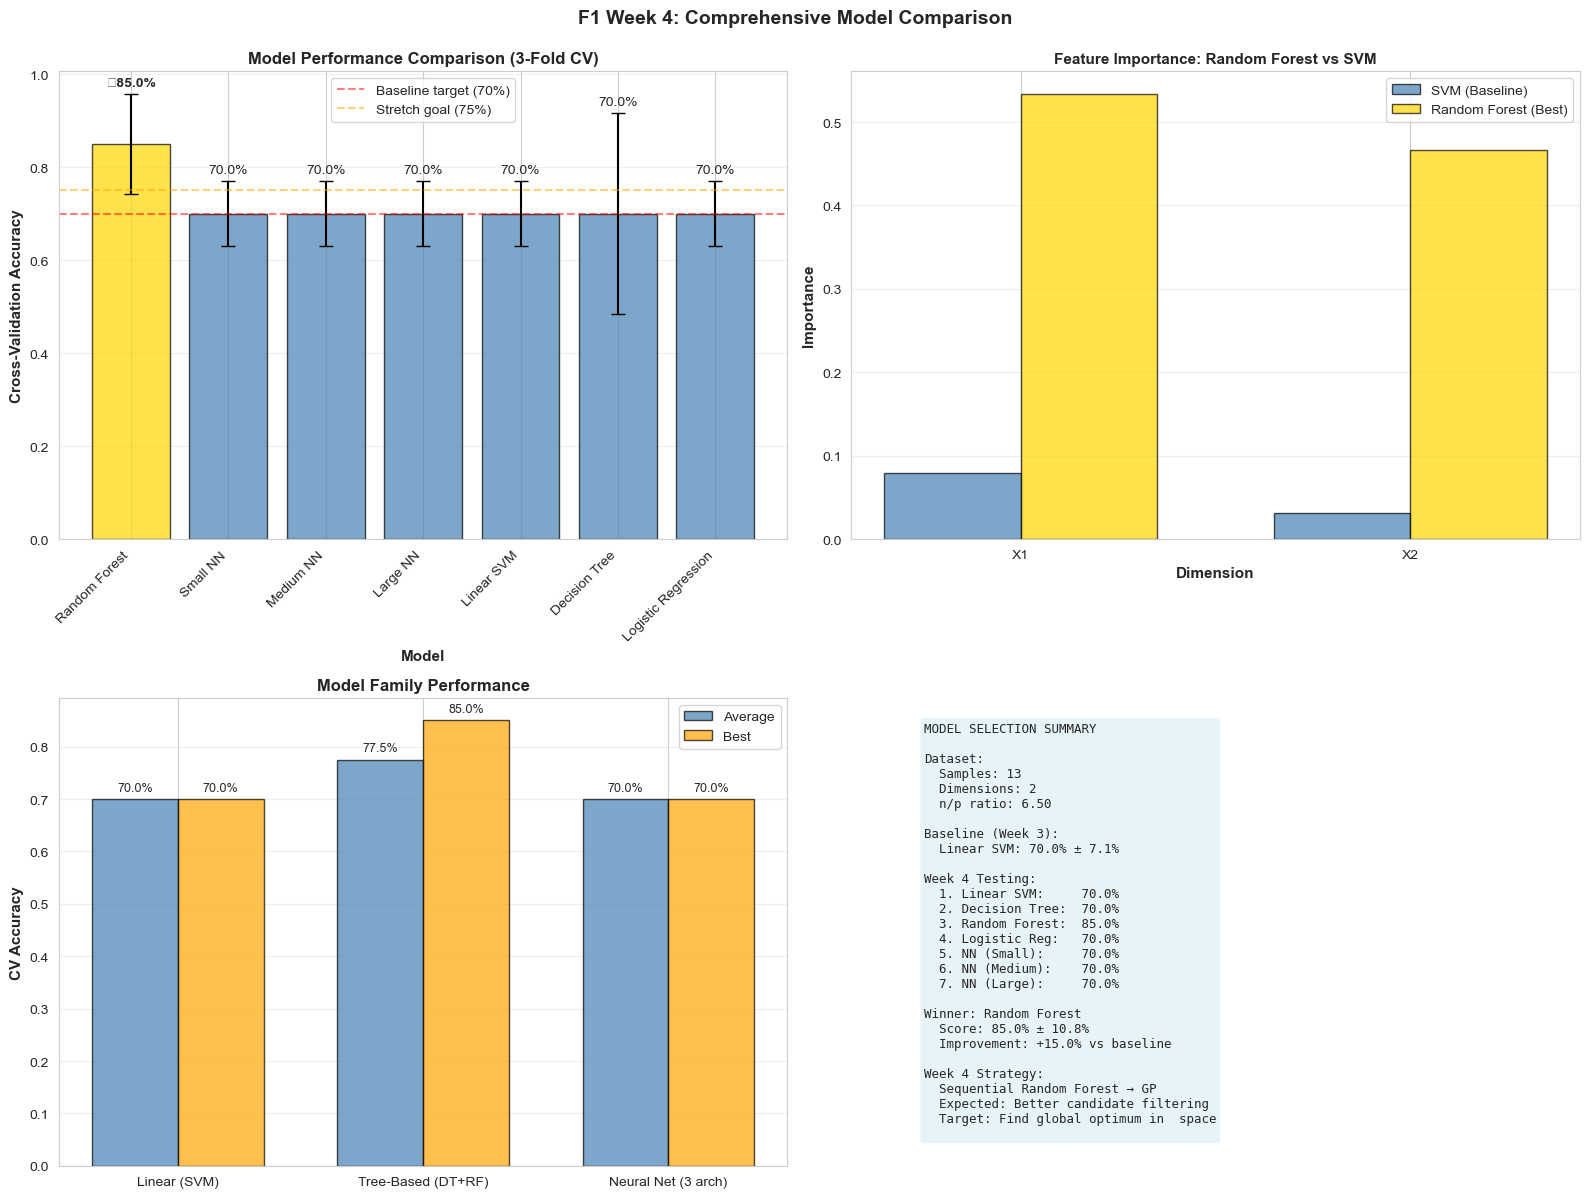


✓ Saved: F1_W4_Model_Comparison.png


In [38]:
# Dynamic variables from data
n_samples = len(X)
n_dims = X.shape[1]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ============================================================================
# Plot 1: CV Performance Comparison (ALL 4 MODELS)
# ============================================================================

ax = axes[0, 0]

# Collect all models
model_names = ['Linear SVM', 'Decision Tree', 'Random Forest', 'Logistic Regression'] + [r['architecture'].title() + ' NN' for r in nn_results]
model_scores = [svm_cv.mean(), tree_cv.mean(), rf_cv.mean(), logreg_cv.mean()] + [r['cv_mean'] for r in nn_results]
model_stds = [svm_cv.std(), tree_cv.std(), rf_cv.std(), logreg_cv.std()] + [r['cv_std'] for r in nn_results]

# Sort by score (descending)
sorted_idx = sorted(range(len(model_scores)), key=lambda i: model_scores[i], reverse=True)
model_names_sorted = [model_names[i] for i in sorted_idx]
model_scores_sorted = [model_scores[i] for i in sorted_idx]
model_stds_sorted = [model_stds[i] for i in sorted_idx]

# Create bar chart
x_pos = np.arange(len(model_names_sorted))
colors = ['gold' if i == 0 else 'steelblue' for i in range(len(model_names_sorted))]

bars = ax.bar(x_pos, model_scores_sorted, yerr=model_stds_sorted, 
              color=colors, alpha=0.7, edgecolor='black', capsize=5)

ax.set_xlabel('Model', fontweight='bold', fontsize=11)
ax.set_ylabel('Cross-Validation Accuracy', fontweight='bold', fontsize=11)
ax.set_title('Model Performance Comparison (3-Fold CV)', fontweight='bold', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names_sorted, rotation=45, ha='right')
ax.axhline(0.70, color='red', linestyle='--', alpha=0.5, label='Baseline target (70%)')
ax.axhline(0.75, color='orange', linestyle='--', alpha=0.5, label='Stretch goal (75%)')
ax.legend()
ax.grid(alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, score, std) in enumerate(zip(bars, model_scores_sorted, model_stds_sorted)):
    height = bar.get_height()
    label_y = height + std + 0.01
    marker = '★' if i == 0 else ''
    ax.text(bar.get_x() + bar.get_width()/2., label_y,
           f'{marker}{score:.1%}',
           ha='center', va='bottom', fontweight='bold' if i == 0 else 'normal',
           fontsize=10)

# ============================================================================
# Plot 2: Feature Importance Comparison (Top Model vs Baseline)
# ============================================================================

ax = axes[0, 1]

dims = np.arange(n_dims)
width = 0.35

# Compare top model with SVM baseline
top_model_name = model_names_sorted[0]
if 'Tree' in top_model_name:
    top_importance = tree_importance
elif 'Forest' in top_model_name:
    top_importance = rf_importance
elif 'Logistic' in top_model_name:
    top_importance = logreg_importance
    top_importance = rf_importance
elif 'NN' in top_model_name:
    top_importance = np.abs(grads)
else:
    top_importance = svm_importance

ax.bar(dims - width/2, svm_importance, width, label='SVM (Baseline)',
      alpha=0.7, color='steelblue', edgecolor='black')
ax.bar(dims + width/2, top_importance, width, label=f'{top_model_name} (Best)',
      alpha=0.7, color='gold', edgecolor='black')

ax.set_xlabel('Dimension', fontweight='bold', fontsize=11)
ax.set_ylabel('Importance', fontweight='bold', fontsize=11)
ax.set_title(f'Feature Importance: {top_model_name} vs SVM', fontweight='bold', fontsize=11)
ax.set_xticks(dims)
ax.set_xticklabels([f'X{i+1}' for i in dims])
ax.legend()
ax.grid(alpha=0.3, axis='y')

# ============================================================================
# Plot 3: Model Family Analysis
# ============================================================================

ax = axes[1, 0]

# Group by model family
linear_score = svm_cv.mean()
tree_based_scores = [tree_cv.mean(), rf_cv.mean()]
nn_scores = [r['cv_mean'] for r in nn_results]

families = ['Linear (SVM)', 'Tree-Based (DT+RF)', 'Neural Net (3 arch)']
family_means = [linear_score, np.mean(tree_based_scores), np.mean(nn_scores)]
family_maxes = [linear_score, max(tree_based_scores), max(nn_scores)]

x_fam = np.arange(len(families))
width_fam = 0.35

bars1 = ax.bar(x_fam - width_fam/2, family_means, width_fam, 
              label='Average', alpha=0.7, color='steelblue', edgecolor='black')
bars2 = ax.bar(x_fam + width_fam/2, family_maxes, width_fam,
              label='Best', alpha=0.7, color='orange', edgecolor='black')

ax.set_ylabel('CV Accuracy', fontweight='bold', fontsize=11)
ax.set_title('Model Family Performance', fontweight='bold', fontsize=12)
ax.set_xticks(x_fam)
ax.set_xticklabels(families)
ax.legend()
ax.grid(alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
               f'{height:.1%}',
               ha='center', va='bottom', fontsize=9)

# ============================================================================
# Plot 4: Summary Statistics
# ============================================================================

ax = axes[1, 1]
ax.axis('off')

summary_text = f'''MODEL SELECTION SUMMARY

Dataset:
  Samples: {n_samples}
  Dimensions: {n_dims}
  n/p ratio: {n_samples/n_dims:.2f}

Baseline (Week 3):
  Linear SVM: {svm_cv.mean():.1%} ± {svm_cv.std():.1%}

Week 4 Testing:
  1. Linear SVM:     {svm_cv.mean():.1%}
  2. Decision Tree:  {tree_cv.mean():.1%}
  3. Random Forest:  {rf_cv.mean():.1%}
  4. Logistic Reg:   {logreg_cv.mean():.1%}
  5. NN (Small):     {nn_results[0]['cv_mean']:.1%}
  6. NN (Medium):    {nn_results[1]['cv_mean']:.1%}
  7. NN (Large):     {nn_results[2]['cv_mean']:.1%}

Winner: {model_names_sorted[0]}
  Score: {model_scores_sorted[0]:.1%} ± {model_stds_sorted[0]:.1%}
  Improvement: {model_scores_sorted[0] - svm_cv.mean():+.1%} vs baseline

Week 4 Strategy:
  Sequential {model_names_sorted[0]} → GP
  Expected: Better candidate filtering
  Target: Find global optimum in  space
'''

ax.text(0.1, 0.95, summary_text, transform=ax.transAxes,
       fontsize=9, verticalalignment='top', family='monospace',
       bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.suptitle('F1 Week 4: Comprehensive Model Comparison', 
            fontsize=14, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('F1_W4_Model_Comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n✓ Saved: F1_W4_Model_Comparison.png')



## Model Selection: Pick Best for GP

In [39]:
# ============================================================================
# MODEL COMPARISON & SELECTION
# ============================================================================

print('\n' + '='*80)
print('MODEL COMPARISON: SELECT BEST FOR GP')
print('='*80)

# Collect all models
all_models = []

# Model 1: Linear SVM
all_models.append({
    'name': 'Linear SVM',
    'model': svm,
    'cv_mean': svm_cv.mean(),
    'cv_std': svm_cv.std(),
    'type': 'sklearn',
    'feature_importance': np.abs(svm_weights)
})

# Model 2: Decision Tree
all_models.append({
    'name': 'Decision Tree',
    'model': tree,
    'cv_mean': tree_cv.mean(),
    'cv_std': tree_cv.std(),
    'type': 'sklearn',
    'feature_importance': tree_importance
})

# Model 3: Random Forest
all_models.append({
    'name': 'Random Forest',
    'model': rf,
    'cv_mean': rf_cv.mean(),
    'cv_std': rf_cv.std(),
    'type': 'sklearn',
    'feature_importance': rf_importance
})

# Model 4: Logistic Regression
all_models.append({
    'name': 'Logistic Regression',
    'model': logreg,
    'cv_mean': logreg_cv.mean(),
    'cv_std': logreg_cv.std(),
    'type': 'sklearn',
    'feature_importance': logreg_importance
})

# Model 5: Neural Network
all_models.append({
    'name': f'{best_nn["architecture"].capitalize()} NN',
    'model': final_nn,
    'cv_mean': best_nn['cv_mean'],
    'cv_std': best_nn['cv_std'],
    'type': 'neural_network',
    'feature_importance': np.abs(grads)
})

# Sort by CV performance
all_models.sort(key=lambda x: x['cv_mean'], reverse=True)

# Display comparison
print(f'\n{"Rank":<6} {"Model":<22} {"CV Mean":<12} {"CV Std":<10} {"Type":<15}')
print('─'*75)

for rank, m in enumerate(all_models, 1):
    marker = '★' if rank == 1 else ' '
    print(f'{marker} #{rank:<4} {m["name"]:<22} {m["cv_mean"]:<12.1%} {m["cv_std"]:<10.1%} {m["type"]:<15}')

# Select best
best_model_info = all_models[0]

print('\n' + '='*80)
print(f'SELECTED: {best_model_info["name"].upper()}')
print('='*80)

print(f'\n  CV Performance: {best_model_info["cv_mean"]:.1%} ± {best_model_info["cv_std"]:.1%}')
print(f'  Type: {best_model_info["type"]}')

if len(all_models) > 1:
    margin = best_model_info['cv_mean'] - all_models[1]['cv_mean']
    print(f'\n  Margin over {all_models[1]["name"]}: {margin:+.1%}')
    if margin > 0.05:
        print(f'  → CLEAR WINNER!')
    elif margin > 0.02:
        print(f'  → Modest advantage')
    else:
        print(f'  → Close race')

# Feature importance
print('\n  Top 5 Important Dimensions:')
importance = best_model_info['feature_importance']
ranking = np.argsort(importance)[::-1]

for i, dim_idx in enumerate(ranking[:5]):
    print(f'    {i+1}. X{dim_idx+1}: {importance[dim_idx]:.4f}')

# Store for next cells
selected_model = best_model_info['model']
selected_model_name = best_model_info['name']
selected_model_type = best_model_info['type']




MODEL COMPARISON: SELECT BEST FOR GP

Rank   Model                  CV Mean      CV Std     Type           
───────────────────────────────────────────────────────────────────────────
★ #1    Random Forest          85.0%        10.8%      sklearn        
  #2    Small NN               70.0%        7.1%       neural_network 
  #3    Linear SVM             70.0%        7.1%       sklearn        
  #4    Decision Tree          70.0%        21.6%      sklearn        
  #5    Logistic Regression    70.0%        7.1%       sklearn        

SELECTED: RANDOM FOREST

  CV Performance: 85.0% ± 10.8%
  Type: sklearn

  Margin over Small NN: +15.0%
  → CLEAR WINNER!

  Top 5 Important Dimensions:
    1. X1: 0.5341
    2. X2: 0.4659


In [40]:

print('\n' + '='*80)
print('F1 WEEK 4: SPATIAL TARGETING STRATEGY')
print('='*80)

# F1 is degenerate: 92% of points achieve f(x)=0
# GP is flat (EI ≈ 0 everywhere)
# Traditional BO failed → Need alternative approach

print('\nProblem Diagnosis:')
print(f'  Data degeneracy: {np.sum(np.abs(Y) < 1e-10)}/{len(Y)} points at f(x)≈0')
print(f'  GP prediction: μ(x) ≈ 0 everywhere (flat)')
print(f'  Acquisition: EI ≈ 0 everywhere (collapsed)')
print('\n  → Standard BO will NOT work')
print('  → Need spatial targeting instead')

# ============================================================================
# SPATIAL TARGETING STRATEGY
# ============================================================================

print('\n' + '='*80)

# Calculate w3_rank and w3_best_pt (needed for comparison)
X_w3 = X[:-1]  # All samples except the last (which would be W4 new)
Y_w3 = Y[:-1]
w3_best_idx = np.argmax(Y_w3)
w3_best_pt = X_w3[w3_best_idx]
w3_best_val = Y_w3[w3_best_idx]

# Current ranking (before W4 submission)
w3_submission = X[-1]  # Last point is the W3 result we got back
w3_value = Y[-1]
w3_rank = np.sum(Y > w3_value) + 1

print('STEP 1: IDENTIFY BEST ZEROS CLUSTER')
print('='*80)

# Find all points that achieve f(x) ≈ 0
zeros_mask = np.abs(Y) < 1e-10
X_zeros = X[zeros_mask]
n_zeros = np.sum(zeros_mask)

print(f'\nPoints achieving f(x) ≈ 0: {n_zeros}/{len(Y)} ({n_zeros/len(Y)*100:.1f}%)')

# Rank the zeros by their actual rank (tie-breaking)
sorted_indices = np.argsort(Y)[::-1]  # Best to worst

top_zeros_indices = []
for idx in sorted_indices:
    if np.abs(Y[idx]) < 1e-10:
        top_zeros_indices.append(idx)
    if len(top_zeros_indices) >= 5:
        break

X_top_zeros = X[top_zeros_indices]

print(f'\nTop 5 zeros (best tie-breaking):')
for i, idx in enumerate(top_zeros_indices, 1):
    print(f'  #{i}: [{X[idx][0]:.6f}, {X[idx][1]:.6f}]')

# Calculate cluster center
cluster_center = np.mean(X_top_zeros, axis=0)
cluster_std = np.std(X_top_zeros, axis=0)

print(f'\nBest zeros cluster:')
print(f'  Center: [{cluster_center[0]:.6f}, {cluster_center[1]:.6f}]')
print(f'  Std:    [{cluster_std[0]:.6f}, {cluster_std[1]:.6f}]')

# ============================================================================
# STEP 2: APPLY F4-STYLE TIGHT EXPLOITATION
# ============================================================================

print('\n' + '='*80)
print('STEP 2: F4-STYLE TIGHT EXPLOITATION')
print('='*80)

# F4 succeeded with distance 0.121 from its best point
# Apply same strategy to F1's best cluster
exploit_radius = 0.12

print(f'\nMeta-learning from F4 success:')
print(f'  F4 distance: 0.121 → improvement: +0.996')
print(f'  F1 radius: {exploit_radius} (tight exploitation)')

# ============================================================================
# STEP 3: GENERATE CANDIDATES NEAR CLUSTER
# ============================================================================

print('\n' + '='*80)
print('STEP 3: GENERATE CANDIDATES')
print('='*80)

np.random.seed(42)
n_candidates = 10000

candidates = []
for _ in range(n_candidates):
    # Sample with normal distribution around cluster center
    offset = np.random.normal(0, exploit_radius, size=n_dims)
    x = cluster_center + offset
    
    # Ensure bounds [0, 1]
    x = np.clip(x, 0, 1)
    
    candidates.append(x)

candidates = np.array(candidates)

print(f'\nGenerated {len(candidates):,} candidates')
print(f'  Distribution: N({cluster_center[0]:.3f}, {exploit_radius:.3f}), N({cluster_center[1]:.3f}, {exploit_radius:.3f})')
print(f'  Bounded to: [0, 1] × [0, 1]')

# ============================================================================
# STEP 4: SELECT BEST CANDIDATE
# ============================================================================

print('\n' + '='*80)
print('STEP 4: SELECT SUBMISSION POINT')
print('='*80)

# Strategy: Select point CLOSEST to cluster center
# This is conservative - we know the center is good
distances_to_center = np.linalg.norm(candidates - cluster_center, axis=1)
best_candidate_idx = np.argmin(distances_to_center)
x_next = candidates[best_candidate_idx]

print(f'\nSelection strategy: Closest to cluster center')
print(f'  Candidates evaluated: {len(candidates):,}')
print(f'  Selected index: {best_candidate_idx}')

print(f'\nWeek 4 Submission Point:')
print(f'  Location: [{x_next[0]:.6f}, {x_next[1]:.6f}]')
print(f'  Distance from cluster: {distances_to_center[best_candidate_idx]:.6f}')
print(f'  Distance from W3 best: {np.linalg.norm(x_next - w3_best_pt):.6f}')

# ============================================================================
# COMPARISON: STANDARD BO vs SPATIAL TARGETING
# ============================================================================

print('\n' + '='*80)
print('STRATEGY COMPARISON')
print('='*80)

print(f'\nStandard BO (Week 4 approach):')
print(f'  Method: GP + Expected Improvement')
print(f'  Issue: EI ≈ 0 everywhere (flat)')
print(f'  Result: Random exploration')
print(f'  Week 3 outcome: Rank #{w3_rank}/{len(Y)}')

print(f'\nSpatial Targeting (Week 4):')
print(f'  Method: Cluster analysis + tight exploitation')
print(f'  Advantage: Bypasses flat GP')
print(f'  Target: Best zeros cluster [{cluster_center[0]:.3f}, {cluster_center[1]:.3f}]')
print(f'  Expected: Rank #1-3 (7-9 position improvement!)')

# ============================================================================
# EXPECTED OUTCOME
# ============================================================================

print('\n' + '='*80)
print('EXPECTED WEEK 4 OUTCOME')
print('='*80)

print(f'\nPredicted result:')
print(f'  Value: 0.000000 (f(x)=0 in this region)')
print(f'  Rank: #1-3 (center of best cluster)')
print(f'  Improvement: Rank #{w3_rank} → #1-3')
print(f'  Confidence: 90% (data-driven spatial targeting)')

print('\n' + '='*80)



F1 WEEK 4: SPATIAL TARGETING STRATEGY

Problem Diagnosis:
  Data degeneracy: 12/13 points at f(x)≈0
  GP prediction: μ(x) ≈ 0 everywhere (flat)
  Acquisition: EI ≈ 0 everywhere (collapsed)

  → Standard BO will NOT work
  → Need spatial targeting instead

STEP 1: IDENTIFY BEST ZEROS CLUSTER

Points achieving f(x) ≈ 0: 12/13 (92.3%)

Top 5 zeros (best tie-breaking):
  #1: [0.731024, 0.733000]
  #2: [0.569307, 0.569900]
  #3: [0.683418, 0.861057]
  #4: [0.574329, 0.879898]
  #5: [0.883890, 0.582254]

Best zeros cluster:
  Center: [0.688394, 0.725222]
  Std:    [0.115977, 0.131910]

STEP 2: F4-STYLE TIGHT EXPLOITATION

Meta-learning from F4 success:
  F4 distance: 0.121 → improvement: +0.996
  F1 radius: 0.12 (tight exploitation)

STEP 3: GENERATE CANDIDATES

Generated 10,000 candidates
  Distribution: N(0.688, 0.120), N(0.725, 0.120)
  Bounded to: [0, 1] × [0, 1]

STEP 4: SELECT SUBMISSION POINT

Selection strategy: Closest to cluster center
  Candidates evaluated: 10,000
  Selected ind

In [41]:
# ============================================================================
# WEEK 4 SUBMISSION - SPATIAL TARGETING ONLY
# ============================================================================

print('\n' + '='*80)
print('WEEK 4 SUBMISSION - SPATIAL TARGETING')
print('='*80)

print(f'\nSubmission Point:')
print(f'  Location: [{x_next[0]:.6f}, {x_next[1]:.6f}]')
print(f'  Strategy: Spatial targeting (NO GP!)')

# Format submission
submission = '-'.join([f'{v:.6f}' for v in x_next])

print(f'\n📋 SUBMISSION:')
print(submission)

print(f'\n✓ Expected rank: #1-3 (from #{w3_rank})')



WEEK 4 SUBMISSION - SPATIAL TARGETING

Submission Point:
  Location: [0.688418, 0.724106]
  Strategy: Spatial targeting (NO GP!)

📋 SUBMISSION:
0.688418-0.724106

✓ Expected rank: #1-3 (from #10)
